In [2]:
### Run once in the new env
%pip install -r requirements.txt -q
!python -m pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


#### Initialization

In [1]:
## libraries 
from sqlalchemy import create_engine, text, Integer, String, Float, Boolean
import matplotlib.pyplot as plt
from pymongo import MongoClient
from pprint import pp # using this to print the json in a pretty format
from time import time 
import seaborn as sns
import pandas as pd 
import dotenv
import os 

plt.style.use('dark_background')

dotenv loads the file `.env` and gets the parameters from there because we are storing DB credentials which needs to be secured. 

In [2]:
## database initialization
dotenv.load_dotenv()


MYSQL_CONFIG = {
    'username': os.environ['mysql_username'],
    'password': os.environ['mysql_password'],
    'host'    : os.environ['mysql_hostname'],
}

MONGO_DB_CONFIG = {
    'username': os.environ['mongo_username'],
    'password': os.environ['mongo_password'],
    'hostname' : os.environ['mongo_hostname'],
    'appName' : os.environ['mongo_appName'],
    'port'    : os.environ['mongo_port']
}

DB_NAME = 'project_test'

In [3]:
### this function drops the specified database and creates it again
def reset_sqlite_database(engine, dbname : str):
    with engine.connect() as connection:
        connection.execute(text(f"DROP DATABASE IF EXISTS {dbname}"))
        connection.execute(text(f"CREATE DATABASE {dbname}"))
    print(f'Recreated the database : [{dbname}]')

In [4]:
# db_url = f"mysql+mysqlconnector://{MYSQL_CONFIG['username']}:{MYSQL_CONFIG['password']}@{MYSQL_CONFIG['host']}:3306"
# engine = create_engine(db_url)
# reset_sqlite_database(engine, dbname = DB_NAME)
db_url = f"mysql+mysqlconnector://{MYSQL_CONFIG['username']}:{MYSQL_CONFIG['password']}@{MYSQL_CONFIG['host']}:3306/{DB_NAME}"
engine = create_engine(db_url)

Loading the essential datasets 

In [100]:
data_folder = 'finance_transaction'
transaction_filename = os.path.join(data_folder, 'transactions_data.csv')
cards_filename = os.path.join(data_folder, 'cards_data.csv')
users_filename = os.path.join(data_folder, 'users_data.csv')

n_rows = 1000000 # using limited rows due to large number of rows  
transaction_df = pd.read_csv(transaction_filename, nrows= n_rows)
cards_df = pd.read_csv(cards_filename, nrows= n_rows)
users_df = pd.read_csv(users_filename, nrows= n_rows)

Descriptive analysis - EDA & Data Cleaning

In [101]:
transaction_df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


In [102]:
cards_df.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [103]:
users_df.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


In [104]:
users_df.describe()

,id,current_age,retirement_age,birth_year,birth_month,latitude,longitude,credit_score,num_credit_cards
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,999.500000,45.391500,66.237500,1973.803000,6.439000,37.389225,-91.554765,709.734500,3.073000
std,577.494589,18.414092,3.628867,18.421234,3.565338,5.114324,16.283293,67.221949,1.637379
min,0.000000,18.000000,50.000000,1918.000000,1.000000,20.880000,-159.410000,480.000000,1.000000
25%,499.750000,30.000000,65.000000,1961.000000,3.000000,33.837500,-97.395000,681.000000,2.000000
50%,999.500000,44.000000,66.000000,1975.000000,7.000000,38.250000,-86.440000,711.500000,3.000000
75%,1499.250000,58.000000,68.000000,1989.000000,10.000000,41.200000,-80.130000,753.000000,4.000000
max,1999.000000,101.000000,79.000000,2002.000000,12.000000,61.200000,-68.670000,850.000000,9.000000


In [105]:
cards_df.describe()

,id,client_id,card_number,cvv,num_cards_issued,year_pin_last_changed
count,6146.000000,6146.000000,6.146000e+03,6146.000000,6146.000000,6146.000000
mean,3072.500000,994.939636,4.820426e+15,506.220794,1.503091,2013.436707
std,1774.341709,578.614626,1.328582e+15,289.431123,0.519191,4.270699
min,0.000000,0.000000,3.001055e+14,0.000000,1.000000,2002.000000
25%,1536.250000,492.250000,4.486365e+15,257.000000,1.000000,2010.000000
50%,3072.500000,992.000000,5.108957e+15,516.500000,1.000000,2013.000000
75%,4608.750000,1495.000000,5.585237e+15,756.000000,2.000000,2017.000000
max,6145.000000,1999.000000,6.997197e+15,999.000000,3.000000,2020.000000


In [59]:
transaction_df.describe()

,id,client_id,card_id,merchant_id,zip,mcc
count,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,884923.00000,1000000.000000
mean,8.074077e+06,1031.404634,3371.447930,47804.559379,51612.02763,5563.689269
std,3.461477e+05,582.522773,1681.930546,25764.304200,29406.86513,872.610520
min,7.475327e+06,0.000000,0.000000,2.000000,1012.00000,1711.000000
25%,7.774100e+06,515.000000,2239.000000,25887.000000,28645.00000,5300.000000
50%,8.073848e+06,1077.000000,3431.000000,46284.000000,48036.00000,5499.000000
75%,8.373562e+06,1534.000000,4718.000000,67570.000000,78130.00000,5812.000000
max,8.674652e+06,1998.000000,6021.000000,100341.000000,99840.00000,9402.000000


In [60]:
### Prints all the column names from a dataframe
def print_col_names_in_df(columns, title = ''):
    print(f' [ {title} ] '.center(80, '='))
    print(pd.DataFrame({
        'column names' : columns
    }).T)
    print()

In [61]:
# uct = [users_df, cards_df, transaction_df]
print_col_names_in_df(users_df.columns, 'Users DF')
print_col_names_in_df(cards_df.columns, 'Cards DF')
print_col_names_in_df(transaction_df.columns, 'Transactions DF')

================================= [ Users DF ] =================================
              0            1               2           3            4   \
column names  id  current_age  retirement_age  birth_year  birth_month   

                  5        6         7          8                  9   \
column names  gender  address  latitude  longitude  per_capita_income   

                         10          11            12                13  
column names  yearly_income  total_debt  credit_score  num_credit_cards  

================================= [ Cards DF ] =================================
              0          1           2          3            4        5    6   \
column names  id  client_id  card_brand  card_type  card_number  expires  cvv   

                    7                 8             9               10  \
column names  has_chip  num_cards_issued  credit_limit  acct_open_date   

                                 11                12  
column names  year_pin_la

In [109]:
### Shows the number of values for each features from a dataframe in a heatmap format
def null_heatmap(df: pd.DataFrame, title = ''):
    nulls = df.isna().sum()
    nulls = nulls.to_frame()  
    # nulls = nulls.T

    sns.heatmap(nulls, annot = True, fmt = 'd', cmap = 'icefire')
    plt.title(title)
    plt.xticks(ticks=[.5], labels=[f'Total Count : {nulls.values.sum()}'])

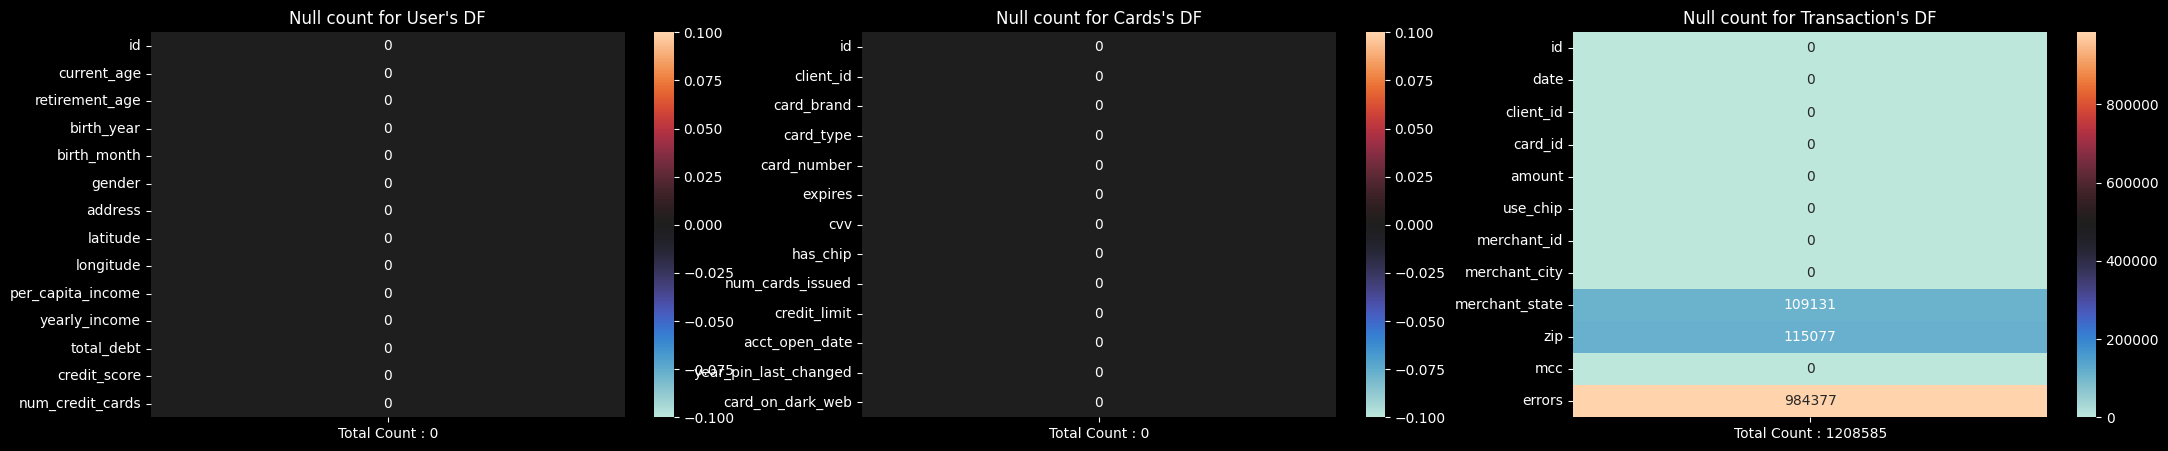

In [63]:
plt.figure(figsize=(26, 5))
plt.tight_layout()

plt.subplot(1,3, 1)
null_heatmap(users_df, "Null count for User's DF")
plt.subplot(1,3, 2)
null_heatmap(cards_df, "Null count for Cards's DF")
plt.subplot(1,3, 3)
null_heatmap(transaction_df, "Null count for Transaction's DF")

Based on the above heatmap, we can see that only the `transactions_df` got null values for 3 columns, we can impute them with something reasonable for the analysis.  

In [110]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   int64  
 1   current_age        2000 non-null   int64  
 2   retirement_age     2000 non-null   int64  
 3   birth_year         2000 non-null   int64  
 4   birth_month        2000 non-null   int64  
 5   gender             2000 non-null   object 
 6   address            2000 non-null   object 
 7   latitude           2000 non-null   float64
 8   longitude          2000 non-null   float64
 9   per_capita_income  2000 non-null   object 
 10  yearly_income      2000 non-null   object 
 11  total_debt         2000 non-null   object 
 12  credit_score       2000 non-null   int64  
 13  num_credit_cards   2000 non-null   int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 218.9+ KB


`per_capita_income` & `yearly_income` & `total_dept` can be usefull during our analysis so we can clean and convert them from object to float64

In [111]:
remove_currency = lambda x: float(x.replace('$','').strip())
users_df['per_capita_income'] = users_df.per_capita_income.apply(remove_currency)
users_df['yearly_income'] = users_df.yearly_income.apply(remove_currency)
users_df['total_debt'] = users_df.total_debt.apply(remove_currency)
users_df[['per_capita_income', 'yearly_income', 'total_debt']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   per_capita_income  2000 non-null   float64
 1   yearly_income      2000 non-null   float64
 2   total_debt         2000 non-null   float64
dtypes: float64(3)
memory usage: 47.0 KB


In [112]:
cards_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     6146 non-null   int64 
 1   client_id              6146 non-null   int64 
 2   card_brand             6146 non-null   object
 3   card_type              6146 non-null   object
 4   card_number            6146 non-null   int64 
 5   expires                6146 non-null   object
 6   cvv                    6146 non-null   int64 
 7   has_chip               6146 non-null   object
 8   num_cards_issued       6146 non-null   int64 
 9   credit_limit           6146 non-null   object
 10  acct_open_date         6146 non-null   object
 11  year_pin_last_changed  6146 non-null   int64 
 12  card_on_dark_web       6146 non-null   object
dtypes: int64(6), object(7)
memory usage: 624.3+ KB


* Let's `card_number` to string from int as they go over the limit for the SQL Integers
* `credit_limit` can be used for analysis too 
* It's better to convert the `has_chip` & `card_on_dark_web` from `YES` & `NO` to Bool as its better for the analysis

In [113]:
cards_df['card_number'] = cards_df.card_number.astype(str)
cards_df['credit_limit'] = cards_df.credit_limit.apply(remove_currency)
cards_df['has_chip'] = cards_df.has_chip.replace({'YES': True, 'NO': False})
cards_df['card_on_dark_web'] = cards_df.card_on_dark_web.replace({'Yes': True, 'No': False})
cards_df[['card_number', 'credit_limit', 'has_chip', 'card_on_dark_web']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   card_number       6146 non-null   object 
 1   credit_limit      6146 non-null   float64
 2   has_chip          6146 non-null   bool   
 3   card_on_dark_web  6146 non-null   bool   
dtypes: bool(2), float64(1), object(1)
memory usage: 108.2+ KB


C:\Users\jaabi\AppData\Local\Temp\ipykernel_4396\4259577858.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cards_df['has_chip'] = cards_df.has_chip.replace({'YES': True, 'NO': False})
C:\Users\jaabi\AppData\Local\Temp\ipykernel_4396\4259577858.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cards_df['card_on_dark_web'] = cards_df.card_on_dark_web.replace({'Yes': True, 'No': False})


In [114]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   id              1000000 non-null  int64  
 1   date            1000000 non-null  object 
 2   client_id       1000000 non-null  int64  
 3   card_id         1000000 non-null  int64  
 4   amount          1000000 non-null  object 
 5   use_chip        1000000 non-null  object 
 6   merchant_id     1000000 non-null  int64  
 7   merchant_city   1000000 non-null  object 
 8   merchant_state  890869 non-null   object 
 9   zip             884923 non-null   float64
 10  mcc             1000000 non-null  int64  
 11  errors          15623 non-null    object 
dtypes: float64(1), int64(5), object(6)
memory usage: 91.6+ MB


We can remove the `$` from the `amount` column for the `transaction_df` too.

In [115]:
transaction_df['amount'] = transaction_df.amount.apply(remove_currency)
transaction_df[['amount']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   amount  1000000 non-null  float64
dtypes: float64(1)
memory usage: 7.6 MB


Since most of the rows will be None for the `errors` from `transactions_df`, lets replace it with `No Errors`

In [116]:
transaction_df.errors.unique()

array([nan, 'Technical Glitch', 'Bad Expiration', 'Bad Card Number',
       'Insufficient Balance', 'Bad PIN', 'Bad CVV', 'Bad Zipcode',
       'Insufficient Balance,Technical Glitch',
       'Bad PIN,Insufficient Balance', 'Bad PIN,Technical Glitch',
       'Bad Expiration,Technical Glitch',
       'Bad Card Number,Bad Expiration',
       'Bad Card Number,Insufficient Balance',
       'Bad Expiration,Insufficient Balance', 'Bad Card Number,Bad CVV',
       'Bad CVV,Technical Glitch', 'Bad Expiration,Bad CVV',
       'Bad CVV,Insufficient Balance'], dtype=object)

Filling those missing values with `No Errors` for the `errors` from `transaction_df` makes more sense rather than leaving it null.

In [117]:
transaction_df['errors'] = transaction_df.errors.fillna('No Errors')
transaction_df.errors.unique()

array(['No Errors', 'Technical Glitch', 'Bad Expiration',
       'Bad Card Number', 'Insufficient Balance', 'Bad PIN', 'Bad CVV',
       'Bad Zipcode', 'Insufficient Balance,Technical Glitch',
       'Bad PIN,Insufficient Balance', 'Bad PIN,Technical Glitch',
       'Bad Expiration,Technical Glitch',
       'Bad Card Number,Bad Expiration',
       'Bad Card Number,Insufficient Balance',
       'Bad Expiration,Insufficient Balance', 'Bad Card Number,Bad CVV',
       'Bad CVV,Technical Glitch', 'Bad Expiration,Bad CVV',
       'Bad CVV,Insufficient Balance'], dtype=object)

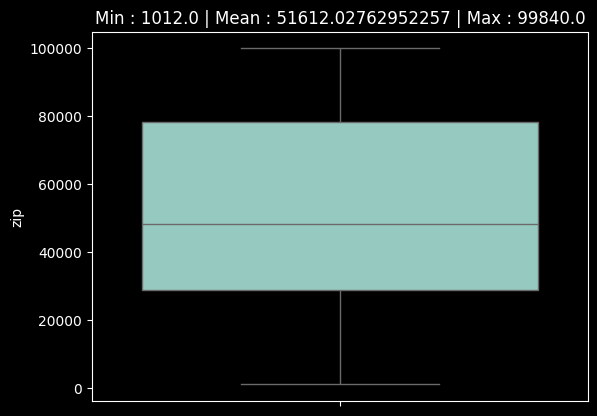

In [72]:
sns.boxplot(transaction_df.zip);
plt.title(f"Min : {transaction_df.dropna().zip.min()} | Mean : {transaction_df.dropna().zip.mean()} | Max : {transaction_df.dropna().zip.max()}");

In [118]:
transaction_df['zip'] = transaction_df.zip.fillna('0')
transaction_df['merchant_state'] = transaction_df.merchant_state.fillna('Unknown')

<span style="color: green;font-weight: bold">All the datasets required for the analysis are cleaned and ready to use</span>

In [119]:
### Saving the cleaned datasets to a new folder incase we need it later
nfolder = 'analysis_data'
if nfolder not in os.listdir():
    os.mkdir(nfolder)

[idf.to_csv(os.path.join(nfolder, iname), index=False) for idf, iname in [(users_df, 'users_data.csv'), (cards_df, 'cards_data.csv'), (transaction_df, 'transactions_data.csv')]]

[None, None, None]

#### MYSQL

In [120]:
### Maps the python datatypes to SQLite datatypes.
def convert_pydt_to_sqldt(dt):
    if dt == 'int64':
        return Integer
    elif dt == 'float64':
        return Float
    elif dt == 'bool':
        return Boolean
    return String(255)

We need to get the SQLite datatypes for all the columns before inserting them to the SQL table.

In [121]:
users_dtypes = {k: convert_pydt_to_sqldt(dt) for k, dt in users_df.dtypes.items()}
cards_dtypes = {k: convert_pydt_to_sqldt(dt) for k, dt in cards_df.dtypes.items()}
transaction_dtypes = {k: convert_pydt_to_sqldt(dt) for k, dt in transaction_df.dtypes.items()}

In [128]:
db_url = f"mysql+mysqlconnector://{MYSQL_CONFIG['username']}:{MYSQL_CONFIG['password']}@{MYSQL_CONFIG['host']}:3306/{DB_NAME}"
engine = create_engine(db_url)

In [137]:
### Creates a chunks of rows based on the given batch_size 
### This takes in the large dataframe and a batch_size as its input and output a list of dataframes where each of those chunk dfs will be in a batch
def create_batch(df, batch_size: int = 100000):
    batch_df = []
    st = 0
    ed = batch_size
    while st < df.shape[0]:
        ed = min(st + batch_size, df.shape[0])
        bdf = df.iloc[st:ed, :]
        batch_df.append(bdf)
        st = ed
        
    return batch_df

Let's split the `transactions_df` since the file is too large to store it in the db at once.

In [138]:
chunks_transaction_df = create_batch(transaction_df)

In [ ]:
# Users
users_create_statement = """CREATE TABLE users (
    id INT PRIMARY KEY,
    current_age INT,
    retirement_age INT,
    birth_year INT,
    birth_month INT,
    gender ENUM('Male', 'Female', 'Other'),
    address VARCHAR(255),
    latitude FLOAT,
    longitude FLOAT,
    per_capita_income FLOAT,
    yearly_income FLOAT,
    total_debt FLOAT,
    credit_score INT,
    num_credit_cards INT
);"""

# Cards
cards_create_statement = """CREATE TABLE cards (
    id INT PRIMARY KEY,
    client_id INT,
    card_brand VARCHAR(255),
    card_type VARCHAR(255),
    card_number VARCHAR(255),
    expires VARCHAR(7) CHECK (expires REGEXP '^(0[1-9]|1[0-2])/[0-9]{4}$'),
    cvv INT,
    has_chip BOOLEAN,
    num_cards_issued INT CHECK (num_cards_issued > 0),
    credit_limit FLOAT,
    acct_open_date VARCHAR(7) CHECK (acct_open_date REGEXP '^(0[1-9]|1[0-2])/[0-9]{4}$'),
    year_pin_last_changed INT,
    card_on_dark_web BOOLEAN
);
"""

# Transactions
transactions_create_statement = """CREATE TABLE transactions (
    id INT PRIMARY KEY,
    date DATE, -- ISO 8601 format corresponds to DATE type in MySQL
    client_id INT,
    card_id INT,
    amount FLOAT,
    use_chip VARCHAR(255), 
    merchant_id INT,       
    merchant_city VARCHAR(255),
    merchant_state VARCHAR(255),
    zip FLOAT,             
    mcc INT,               
    errors VARCHAR(255)
);
"""

we can use this create table queries to create the table. But, we can also use SQLite engine to store the rows directly from the dataframe to the sql without needing to use the For loops and INSERT TABLE queries in one line of code.

In [141]:
from sqlalchemy.orm import sessionmaker
from tqdm import tqdm

Session = sessionmaker(bind=engine)
session = Session()

### inserting to the mysql database using SQLite engine & pandas 
try:
    if session.is_active:
        session.rollback()
        
    users_df.to_sql('users', con=engine, if_exists='replace', method='multi', dtype=users_dtypes)
    cards_df.to_sql('cards', con=engine, if_exists='replace', method='multi', dtype=cards_dtypes)
    ### inserting the rows in batches sequentially for the smoother process 
    for cdf in tqdm(chunks_transaction_df):
        cdf.to_sql('transactions', con=engine, if_exists='append', method='multi', dtype=transaction_dtypes)
    session.commit()  
except Exception as e:
    session.rollback()  
    print("Error occurred: ", e)
finally:
    session.close()

100%|██████████| 10/10 [03:43<00:00, 22.31s/it]


In [7]:
### A decorator to note the time of the function's execution time in ms 
def timeit(function):
    def wrapper(*args, **kwargs):
        st = time()
        result = function(*args, **kwargs)
        ed = time()
        ms = round((ed - st) * 1000, 4)
        print(f'Executed the code in : {ms} ms')
        return result
    return wrapper

### This function takes in the SQLite engine and query and outputs the result along with the number of rows collected from the given query.
@timeit
def execute_engine(engine, query, limit_view = -1):
    if limit_view > 0:
        print(f'Limiting the view to {limit_view}')
    print()
    with engine.connect() as connection:
        result = list(connection.execute(text(query)))
        for nums, row in enumerate(result):
            if limit_view < 0 or nums < limit_view:
                print(row)
            else: break
    
    print(f'Total Number of Documents Collected: {len(result)}')

In [8]:
#Select users with a credit score greater than 750.
q1 = "SELECT id, current_age, yearly_income, credit_score FROM Users WHERE credit_score > 750;"
execute_engine(engine, q1, 5)

Limiting the view to 5

(825, 53, 59696.0, 787)
(1116, 81, 42509.0, 755)
(1752, 34, 38190.0, 810)
(192, 27, 56164.0, 761)
(1679, 18, 69149.0, 776)
Total Number of Documents Collected: 524
Executed the code in : 2.5623 ms


In [9]:
#Select all transactions where errors occurred.
q2 = "SELECT id, date, card_id, amount, errors FROM Transactions WHERE errors IS NOT NULL AND errors != 'No Errors';"
execute_engine(engine, q2, 5)

Limiting the view to 5

(7475516, '2010-01-01 04:56:00', 3233, 104.1, 'Technical Glitch')
(7475611, '2010-01-01 06:10:00', 1127, 28.84, 'Bad Expiration')
(7475643, '2010-01-01 06:19:00', 1127, 38.58, 'Bad Card Number')
(7475792, '2010-01-01 07:02:00', 4710, -72.0, 'Insufficient Balance')
(7475881, '2010-01-01 07:22:00', 184, 37.54, 'Insufficient Balance')
Total Number of Documents Collected: 15623
Executed the code in : 1388.2749 ms


In [10]:
#Calculate the total transaction amount per state for female users.
q3 = """SELECT U.gender, T.merchant_state, SUM(T.amount) AS total_spent FROM Transactions T 
        JOIN Users U ON T.client_id = U.id WHERE U.gender = 'Female' GROUP BY T.merchant_state;"""
execute_engine(engine, q3, 5)

Limiting the view to 5

('Female', 'ND', 13439.22005301714)
('Female', 'IN', 425867.2800893709)
('Female', 'NY', 1624759.0598602444)
('Female', 'Unknown', 3316161.5595796295)
('Female', 'CA', 2219893.7906959746)
Total Number of Documents Collected: 109
Executed the code in : 1462.4133 ms


In [11]:
#Find all cards flagged as "on_dark_web" that were used in transactions exceeding $1,000.
q4 = """SELECT C.card_number, C.card_brand, T.amount, T.date
               FROM Transactions T
               JOIN Cards C ON T.card_id = C.id
               WHERE C.card_on_dark_web = 1 AND T.amount > 1000;"""
execute_engine(engine, q4, 5)

Limiting the view to 5

Total Number of Documents Collected: 0
Executed the code in : 16.5825 ms


The above query didnt give any results because there are no cards that are on the dark web.

#### Mongo DB

In [4]:

uri = f'mongodb://{MONGO_DB_CONFIG["hostname"]}:{MONGO_DB_CONFIG["port"]}/?directConnection=true&serverSelectionTimeoutMS=2000&appName={MONGO_DB_CONFIG["appName"]}+2.3.3'
client = MongoClient(uri)
client.test

Database(MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True, directconnection=True, serverselectiontimeoutms=2000, appname='mongosh 2.3.3'), 'test')

In [5]:
### Drops all the collections from the DB 
def drop_collections(db):
    clists = db.list_collection_names()
    for col in clists:
        print(f'Dropping collection: {col}')
        db.drop_collection(col)

### Test the connection
try:
    db = client[DB_NAME]
    print(f"Connected to the Database: [{DB_NAME}]")
    
    server_status = db.command("serverStatus")
    # print("Server Status:", server_status)
except Exception as e:
    print("Could not connect to MongoDB:", e)

Connected to the Database: [project_test]


In [15]:
print(db.list_collection_names())
# drop_collections(db)
print(db.list_collection_names())

['transactions', 'cards', 'users']
['transactions', 'cards', 'users']


In [ ]:
#Users collection
db.create_collection("users", validator = {
  "$jsonSchema": {
    "bsonType": "object",
    "required": ["id", "current_age", "retirement_age", "birth_year", "birth_month", "gender", "address", "latitude", "longitude", "per_capita_income", "yearly_income", "total_debt", "credit_score", "num_credit_cards"],
    "properties": {
      "id": {
        "bsonType": "int",
        "description": "Must be an integer and is required."
      },
      "current_age": {
        "bsonType": "int",
        "description": "Must be an integer and is required."
      },
      "retirement_age": {
        "bsonType": "int",
        "description": "Must be an integer and is required."
      },
      "birth_year": {
        "bsonType": "int",
        "description": "Must be an integer representing the year of birth and is required."
      },
      "birth_month": {
        "bsonType": "int",
        "description": "Must be an integer representing the month of birth and is required."
      },
      "gender": {
        "bsonType": "string",
        "enum": ["Male", "Female", "Other"],
        "description": "Must be a string and one of the predefined values."
      },
      "address": {
        "bsonType": "string",
        "description": "Must be a string representing the address and is required."
      },
      "latitude": {
        "bsonType": "double",
        "description": "Must be a float representing the latitude coordinate and is required."
      },
      "longitude": {
        "bsonType": "double",
        "description": "Must be a float representing the longitude coordinate and is required."
      },
      "per_capita_income": {
        "bsonType": "double",
        "description": "Must be a float formatted as currency and is required."
      },
      "yearly_income": {
        "bsonType": "double",
        "description": "Must be a float formatted as currency and is required."
      },
      "total_debt": {
        "bsonType": "double",
        "description": "Must be a float formatted as currency and is required."
      },
      "credit_score": {
        "bsonType": "int",
        "description": "Must be an integer representing the credit score and is required."
      },
      "num_credit_cards": {
        "bsonType": "int",
        "description": "Must be an integer representing the number of credit cards and is required."
      }
    }
  }
}
)

In [ ]:
db.create_collection("cards", validator = {
  "$jsonSchema": {
    "bsonType": "object",
    "required": [
      "id",
      "client_id",
      "card_brand",
      "card_type",
      "card_number",
      "expires",
      "cvv",
      "has_chip",
      "num_cards_issued",
      "credit_limit",
      "acct_open_date",
      "year_pin_last_changed",
      "card_on_dark_web"
    ],
    "properties": {
      "id": {
        "bsonType": "int",
        "description": "must be an integer and is required"
      },
      "client_id": {
        "bsonType": "int",
        "description": "must be an integer and is required"
      },
      "card_brand": {
        "bsonType": "string",
        "description": "must be a string and is required"
      },
      "card_type": {
        "bsonType": "string",
        "description": "must be a string and is required"
      },
      "card_number": {
        "bsonType": ["string", "long"],
        "description": "must be a string and is required"
      },
      "expires": {
        "bsonType": "string",
        "pattern": "^(0[1-9]|1[0-2])/[0-9]{4}$",
        "description": "must be in MM/YYYY format"
      },
      "cvv": {
        "bsonType": "int",
        "description": "must be an integer and is required"
      },
      "has_chip": {
        "bsonType": "bool",
        "description": "must be a boolean and is required"
      },
      "num_cards_issued": {
        "bsonType": "int",
        "description": "must be an integer greater than 0"
      },
      "credit_limit": {
        "bsonType": "double",
        "description": "must be a float and is required"
      },
      "acct_open_date": {
        "bsonType": "string",
        "pattern": "^(0[1-9]|1[0-2])/[0-9]{4}$",
        "description": "must be in MM/YYYY format"
      },
      "year_pin_last_changed": {
        "bsonType": "int",
        "description": "must be an integer and is required"
      },
      "card_on_dark_web": {
        "bsonType": "bool",
        "description": "must be a boolean and is required"
      }
    }
  }
}
)

In [ ]:
#Transactions collection
db.create_collection("transactions", validator = {
    "$jsonSchema": {
      "bsonType": "object",
      "required": ["id", "date", "client_id", "card_id", "amount", "merchant_city", "merchant_state", "errors"],
      "properties": {
        "id": {
          "bsonType": "int",
          "description": "Must be an integer and is required."
        },
        "date": {
          "bsonType": "string",
          "description": "Must be a string in ISO 8601 date format and is required."
        },
        "client_id": {
          "bsonType": "int",
          "description": "Must be an integer and is required."
        },
        "card_id": {
          "bsonType": "int",
          "description": "Must be an integer and is required."
        },
        "amount": {
          "bsonType": "double",
          "description": "Must be a float representing a monetary value and is required."
        },
        "use_chip": {
          "bsonType": "string",
          "description": "Must be a string indicating the transaction type if provided."
        },
        "merchant_id": {
          "bsonType": "int",
          "description": "Must be an integer if provided."
        },
        "merchant_city": {
          "bsonType": "string",
          "description": "Must be a string representing a city name and is required."
        },
        "merchant_state": {
          "bsonType": "string",
          "description": "Must be a string representing a state code and is required."
        },
        "zip": {
          "bsonType": "double",
          "description": "Must be a float representing a ZIP code if provided."
        },
        "mcc": {
          "bsonType": "int",
          "description": "Must be an integer representing a Merchant Category Code if provided."
        },
        "errors": {
          "bsonType": "string",
          "description": "Must be a string and is required."
        }
      }
    }
  }
)

In [16]:
users_collection = db['users']
cards_collection = db['cards']
transactions_collection = db['transactions']

In [167]:
### inserting the documents to the mongo db 
users_collection.insert_many(users_df.to_dict(orient='records'), ordered= False)
cards_collection.insert_many(cards_df.to_dict(orient='records'), ordered= False)

### Again inserting the transaction_df in batches
for cdf in tqdm(chunks_transaction_df):
    transactions_collection.insert_many(cdf.to_dict(orient='records'), ordered= False)

100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


In [17]:
#Query Objective: Select users with a credit score greater than 750.
print('Select users with a credit score greater than 750.')
st = time()
result = users_collection.find({"credit_score": {"$gt": 750}})
ed = time()
ms = round((ed - st) * 1000, 4)
print('Total number of docs collected : ', users_collection.count_documents({"credit_score": {"$gt": 750}}))
print(f'Executed the code in : {ms} ms')

for ind, res in enumerate(result):
    if ind >= 5:
        break
    print("=".center(80,'='))
    pp(res)
    print()

Select users with a credit score greater than 750.
Total number of docs collected :  524
Executed the code in : 0.0 ms
{'_id': ObjectId('674b2bbc308e5d56377c9626'),
 'id': 825,
 'current_age': 53,
 'retirement_age': 66,
 'birth_year': 1966,
 'birth_month': 11,
 'gender': 'Female',
 'address': '462 Rose Lane',
 'latitude': 34.15,
 'longitude': -117.76,
 'per_capita_income': 29278.0,
 'yearly_income': 59696.0,
 'total_debt': 127613.0,
 'credit_score': 787,
 'num_credit_cards': 5}

{'_id': ObjectId('674b2bbc308e5d56377c962e'),
 'id': 1116,
 'current_age': 81,
 'retirement_age': 66,
 'birth_year': 1938,
 'birth_month': 7,
 'gender': 'Female',
 'address': '11 Spruce Avenue',
 'latitude': 40.32,
 'longitude': -75.32,
 'per_capita_income': 26273.0,
 'yearly_income': 42509.0,
 'total_debt': 2895.0,
 'credit_score': 755,
 'num_credit_cards': 5}

{'_id': ObjectId('674b2bbc308e5d56377c962f'),
 'id': 1752,
 'current_age': 34,
 'retirement_age': 60,
 'birth_year': 1986,
 'birth_month': 1,
 'gender'

In [18]:
print('Select all transactions where errors occurred.')
#Query Objective: Select all transactions where errors occurred.
st = time()
results = transactions_collection.find({"errors": {"$ne" : "No Errors"}})
ed = time()
ms = round((ed - st) * 1000, 4)
print('Total number of docs collected : ', transactions_collection.count_documents({"errors": {"$ne" : "No Errors"}}))
print(f'Executed the code in : {ms} ms')
print()
for ind, result in enumerate(results):
    if ind >= 5:
        break
    print(f"Client ID: {result['client_id']} | Used Chip: {result['use_chip']} | Error Type: {result['errors']}")

Select all transactions where errors occurred.
Total number of docs collected :  15623
Executed the code in : 0.0 ms

Client ID: 464 | Used Chip: Swipe Transaction | Error Type: Technical Glitch
Client ID: 1797 | Used Chip: Online Transaction | Error Type: Bad Expiration
Client ID: 1797 | Used Chip: Online Transaction | Error Type: Bad Card Number
Client ID: 1424 | Used Chip: Swipe Transaction | Error Type: Insufficient Balance
Client ID: 843 | Used Chip: Swipe Transaction | Error Type: Insufficient Balance


In [20]:
#Query Objective: Calculate the total transaction amount per state for female users.
female_transactions_state_pipeline= [
    {
        "$match": {
            "gender": "Female"
        }
    },
    {
        "$lookup": {
            "from": "transactions",  
            "localField": "id",  
            "foreignField": "client_id",  
            "as": "user_transactions"  
        }
    },
    {
        "$unwind": "$user_transactions"
    },
    {
        "$group": {
            "_id": "$user_transactions.merchant_state",  
            "total_amount": {
                "$sum": {
                    "$toDouble": "$user_transactions.amount"  
                }
            }
        }
    },
    {
        "$sort": {
            "total_amount": -1
        }
    },
    {
        "$limit": 100
        }
]

st = time()
result = users_collection.aggregate(female_transactions_state_pipeline)
ed = time()
ms = round((ed - st) * 1000, 4)
print(f'Executed the code in : {ms} ms')
data = []
for state in result:
    data.append([state['_id'], round(state['total_amount'], 2)])

pd.DataFrame(data = data, columns= ['State_ID', 'Total Amount']).T

Executed the code in : 670512.6662 ms


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
State_ID,Unknown,CA,NY,TX,FL,IL,NJ,PA,OH,NC,...,Belgium,Singapore,Lithuania,Croatia,Tuvalu,Russia,Mongolia,Israel,Kenya,Norway
Total Amount,3316161.56,2219893.79,1624759.06,1435418.16,1104453.74,800431.35,736652.54,711954.83,678030.68,603127.94,...,283.42,262.05,256.83,232.18,231.41,223.02,221.48,209.33,189.14,183.79


The above complex query took more than a few mins to give the result compared to mysql. one possible solution for this would be using Indexing. 

In [19]:
#Query Objective: Find all cards flagged as "on_dark_web" that were used in transactions exceeding $1,000.
dark_web_pipeline = [
    {
        "$match": {
            "card_on_dark_web": True # for now using No because there are no Yes 
        }
    },
    {
        "$lookup": {
            "from": "transactions",  
            "localField": "id",  
            "foreignField": "card_id",  
            "as": "transactions"  
        }
    },
    {
        "$unwind": "$transactions"
    },
    {
        "$addFields": {
            "transactions.amount": {
                "$toDouble": "$transactions.amount"  
            }
        }
    },
    {
        "$match": {
            "transactions.amount": {"$gt": 100}
        }
    }
]

st = time()
result = cards_collection.aggregate(dark_web_pipeline)
ed = time()
ms = round((ed - st) * 1000, 4)
print(f'Executed the code in : {ms} ms')

for ind, card in enumerate(result):
    print(f" {ind} ".center(80, '='))
    print(f"Card ID: {card['id']}, Card Brand: {card['card_brand']}, Card Type: {card['card_type']}")
    print(f"Transaction Amount: ${card['transactions']['amount']}, Date: {card['transactions']['date']}")
    print(f"Merchant State: {card['transactions']['merchant_state']}, On Dark Web: {card['card_on_dark_web']}")

Executed the code in : 8.2405 ms


The above query didn't give any results just like mysql since there are no cards that are on the dark web. 

Based on the execution time of the queries for mysql and mongo db, overall the mongo db was faster. However, it took huge amount of time to output one of the complex queries. mysql was faster than the mongo db for that one query (q3). 